# Quick analysis of the VIE/VIA contracts available on *civiweb.com*

This Jupyter notebook is designed to use data from the civiweb website that you can get by using the following scraper : https://github.com/Toffaa/Civiweb_Scraper.

VIE and VIA are a specific kind of international internship in company or administration, that are managed in France by an organization called Business France. More information can be found at the following address : https://www.civiweb.com/EN/le-volontariat-international.aspx.

The purpose of this notebook is to describe quickly the extracted data, and to get some interesting informations both from Business France and applicants perspectives.

In [15]:
# Importing the data
import pandas as pd

df = pd.read_json('data/offers.json')
df = df[df['Reference'] != 'N/A']
print(df.columns)
print('Number of offers :', df.shape[0])

Index(['URL', 'Reference', 'Title', 'Country', 'City', 'StartDate', 'EndDate',
       'NumberOfMonths', 'Organization', 'Salary', 'NumberOfJobs',
       'DesiredExperience', 'EducationLevel', 'Languages', 'Competence',
       'Diploma', 'PublicationDate', 'PublisherCity', 'TypeOfContract'],
      dtype='object')
Number of offers : 1848


To make country analyses, we need to transform the French names of countries gathered with the scraper into 

In [16]:
import pycountry
import gettext
from unidecode import unidecode

def get_country_code(french_name):
    fr = gettext.translation('iso3166', pycountry.LOCALES_DIR, languages=['FR'])
    fr.install()
    country_code = ''.join([country.alpha_3 for country in pycountry.countries if unidecode(fr.gettext(country.name).upper()) == french_name])
    return country_code

df['CountryAlpha3'] = df['Country'].apply(get_country_code)
print('Unrecognized countries :', df[df['CountryAlpha3'] == ''].Country.unique())

Unrecognized countries : ['VIETNAM' 'REPUBLIQUE TCHEQUE' 'RUSSIE' 'MYANMAR (EX BIRMANIE)'
 'COREE DU SUD' 'TAIWAN' 'GUINEE-BISSAO' 'LAOS']


In [17]:
# Mapping the unrecognized country manually
map = {'VIETNAM' : 'VNM','REPUBLIQUE TCHEQUE' : 'CZE','RUSSIE' : 'RUS','MYANMAR (EX BIRMANIE)' : 'MMR','COREE DU SUD' : 'KOR','TAIWAN' : 'TWN','GUINEE-BISSAO' : 'GNB','LAOS' : 'LAO'}
temp = df['Country'].map(map, na_action='ignore')
df['CountryAlpha3'].update(temp)

Now, I would like to answer to the following questions :

- How VIE are distributed around the world ?
- Where the salary of the VIE are the highest comparated to the local median income ?

To do so, I'm going to create a dataframe containing the required data grouped by country code.

*NB It would have been much more accurate to use cities instead of countries to do this analysis (as in USA or China for example, the salary changes in big cities). However, it requires a lot of work on the data cleansing and aggregating part, and that's not the purpose of this notebook.*

In [18]:
# Creating a new dataframe with the median income by country.
df_country = pd.read_csv('data/net_income.csv')
temp = df_country['Country'].apply(pycountry.countries.search_fuzzy)
df_country['Code'] = temp.apply(lambda x : x[0].alpha_3)
df_country.set_index('Code', inplace=True)

# Grouping the main dataframe by country code, and appending the values to the new dataframe
df['Salary'] = pd.to_numeric(df['Salary'])
df_country['AverageSalaryVIE'] = df.groupby('CountryAlpha3').Salary.mean()
df_country['NumberOfVIE'] = df.groupby('CountryAlpha3').Salary.count()
df_country['PercentOfVIE'] = df_country['NumberOfVIE'].apply(lambda x: round(x / df_country['NumberOfVIE'].sum() * 100, 1))
df_country['IncomeDifference'] = df_country['AverageSalaryVIE'] - df_country['Income']

# Removing entries where there is no VIE offer.
df_country = df_country[df_country['AverageSalaryVIE'].isnull() == False]

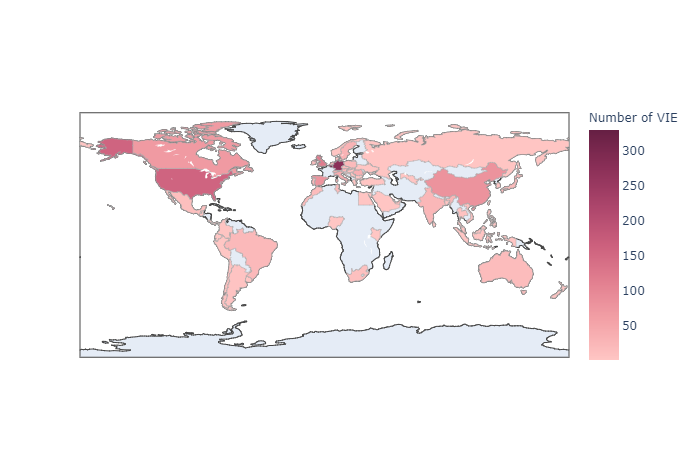

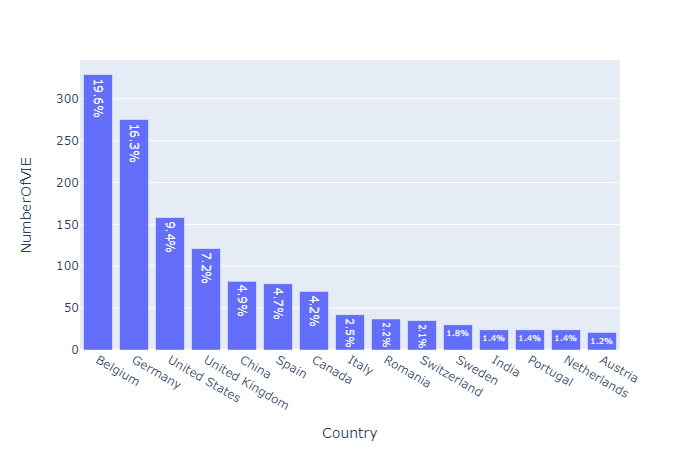

80.30000000000003

In [19]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

world = go.Figure(data=go.Choropleth(
    locations = df_country.index,
    z = df_country['NumberOfVIE'],
    text = df_country['Country'],
    colorscale = 'Burg',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Number of VIE',
))

df_country.sort_values('NumberOfVIE', ascending=False, inplace=True)
fig = px.bar(df_country.head(15), x='Country', y='NumberOfVIE', text=df_country['PercentOfVIE'].head(15).astype(str)+'%')

world.show(renderer="png")
fig.show(renderer="png")
df_country['PercentOfVIE'].head(15).sum()

This second graph only displays the 15 countries where there are the most offers, as they represent 80% of the offers. We can observe than a third of the offers are based in Belgium and Germany.

For the following graphs, please note that I'm using a dataset of which I don't know the quality. Since an apprentice's salary is not subject to income tax, this analysis is to be taken with caution 

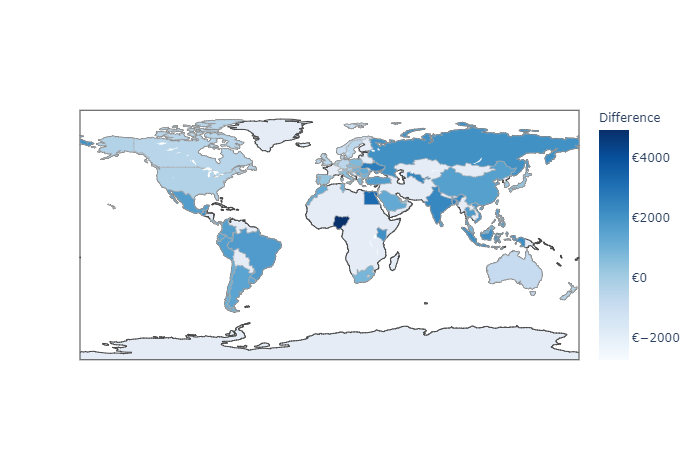

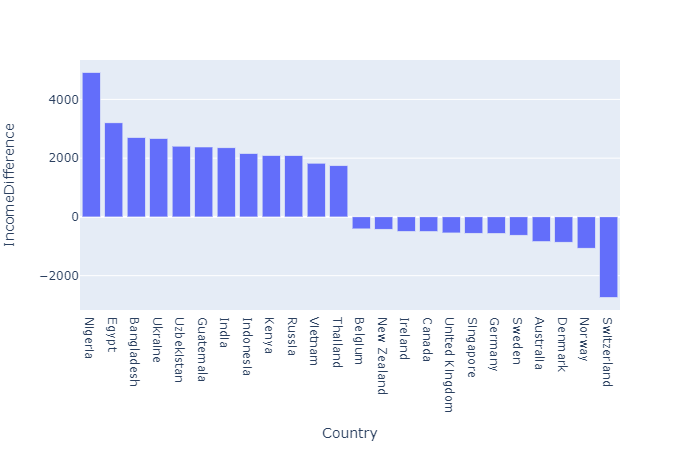

In [20]:
world = go.Figure(data=go.Choropleth(
    locations = df_country.index,
    z = df_country['IncomeDifference'],
    text = df_country['Country'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=False,
    colorbar_tickprefix = '€',
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Difference',
))


df_country.sort_values('IncomeDifference', ascending=False, inplace=True)
df_temp = df_country.head(12).append(df_country.tail(12))
fig = px.bar(df_temp, x='Country', y='IncomeDifference')

world.show(renderer="png")
fig.show(renderer="png")

More intersting things could be done, but that's no the goal of this project. I'd like to thank you for reading, please don't hesitate to contact me for any further information !